<a href="https://colab.research.google.com/github/Ashraf-Al-Aodat/For-a-better-Classification-of-Bacteria-Digital-Image-using-Deep-Learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/My Drive/ML/Digital Image of Bacterial Species /Digital Image of Bacterial Species.zip"

Archive:  /content/drive/My Drive/ML/Digital Image of Bacterial Species /Digital Image of Bacterial Species.zip
   creating: Digital Image of Bacterial Species/
   creating: Digital Image of Bacterial Species/Acinetobacter.baumanii/
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0001.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0002.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0003.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0004.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0005.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0006.tif  
  inflating: Digital Image of Bacterial Species/Acinetobacter.baumanii/Acinetobacter.baumanii_0007.tif  
  inflating: Digital Image of Ba

In [ ]:
import numpy as np
import cv2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


files = os.listdir('Digital Image of Bacterial Species')

factor = 3

label = 0;
y = []
x = []
classes = []
for file in files:
  print(file)
  images = os.listdir('Digital Image of Bacterial Species/' + file)
  for image in images:
    image_path = 'Digital Image of Bacterial Species/' + file + '/' + image
    classes.append(file)
    image = cv2.imread(image_path)
    if type(image) != type(None):
      image = cv2.resize(image, (int(image.shape[0] / factor), int(image.shape[1] / factor)))
      x.append(image)
      y.append(label)
  label = label + 1

print('\nDone\n')
classes = []
for file in files:
  classes.append(file)

print('Creating x & y as numpy')

x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32)

print('Creating 5 Folds')

folds = []
for train_index, test_index in StratifiedKFold(n_splits=5).split(x, y):
  folds.append([train_index, test_index])

print('\nDone\n')

Bacteroides.fragilis
Porfyromonas.gingivalis
Micrococcus.spp
Lactobacillus.rhamnosus
Propionibacterium.acnes
Veionella
Lactobacillus.crispatus(1)
Staphylococcus.saprophiticus
Listeria.monocytogenes
Pseudomonas.aeruginosa
Escherichia.coli
Fusobacterium
Lactobacillus.paracasei
Lactobacillus.salivarius
Lactobacillus.delbrueckii(1)
Clostridium.perfringens
Bifidobacterium.spp
Candida.albicans
Neisseria.gonorrhoeae
Lactobacillus.casei
Acinetobacter.baumanii
Lactobacillus.gasseri(1)
Staphylococcus.aureus
Actinomyces.israeli
Lactobacillus.reuteri
Enterococcus.faecium
Enterococcus.faecalis
Lactobacillus.jehnsenii
Lactobacillus.johnsonii
Proteus
Streptococcus.agalactiae
Staphylococcus.epidermidis
Lactobacillus.plantarum
Creating x & y


In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def show_con(model, x, y):

  con_mat = tf.math.confusion_matrix(labels=y, predictions=model.predict(x).argmax(1)).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

  figure = plt.figure(figsize=(16, 16))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

batch_size = 10
epochs = 50

def schedulerExp(epoch, lr):
    return lr * tf.math.exp(-0.1)

def get_callbacks(patience_lr):
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    learningRateScheduler = LearningRateScheduler(schedulerExp)
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5)
    return [reduce_lr_loss, learningRateScheduler]#, earlyStopping]

def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    drop = tf.keras.layers.Dropout(0.25)(global_average_layer)
    drop = tf.keras.layers.Dropout(0.5)(drop)
    prediction_layer = tf.keras.layers.Dense(33, activation='softmax')(drop)
    
    lr = 1e-3 

    opt = tf.keras.optimizers.Adam(lr=lr, decay=lr / epochs)
    loss = loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(opt, loss, metrics=["accuracy"])
    return model


def fit_model(model, x_train_cv, y_train_cv, x_valid_cv, y_valid_cv):
  
  callbacks = get_callbacks(patience_lr=5)
  history = model.fit(x=x_train_cv, y=y_train_cv, steps_per_epoch=len(x_train_cv) / batch_size, epochs=epochs,
                      batch_size=batch_size, shuffle=True, verbose=1,
                      validation_data = (x_valid_cv, y_valid_cv), callbacks = callbacks)
  return history

base_model = tf.keras.applications.Xception(input_shape=x[0].shape, include_top=False, weights="imagenet")

#base_model = tf.keras.applications.DenseNet201(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.InceptionResNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.ResNet152V2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.InceptionV3(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.NASNetLarge(input_shape=x_train[0].shape, include_top=False, weights="imagenet")
#base_model = tf.keras.applications.EfficientNetB7(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

83689472/83683744 [==============================] - 1s 0us/step



Fold  0
                   
Epoch 1/50
55/55 [==============================] - 133s 2s/step - loss: 3.5162 - accuracy: 0.0326 - val_loss: 4.3162 - val_accuracy: 0.0580
Epoch 2/50
55/55 [==============================] - 90s 2s/step - loss: 3.0775 - accuracy: 0.2177 - val_loss: 5.9926 - val_accuracy: 0.0290
Epoch 3/50
55/55 [==============================] - 91s 2s/step - loss: 1.8823 - accuracy: 0.4057 - val_loss: 3.2001 - val_accuracy: 0.2464
Epoch 4/50
55/55 [==============================] - 91s 2s/step - loss: 1.0290 - accuracy: 0.6788 - val_loss: 2.4983 - val_accuracy: 0.3043
Epoch 5/50
55/55 [==============================] - 91s 2s/step - loss: 0.6839 - accuracy: 0.7986 - val_loss: 4.3483 - val_accuracy: 0.2899
Epoch 6/50
55/55 [==============================] - 91s 2s/step - loss: 0.5193 - accuracy: 0.8208 - val_loss: 0.4416 - val_accuracy: 0.8696
Epoch 7/50
55/55 [==============================] - 90s 2s/step - loss: 0.3546 - accuracy: 0.9057 - val_loss: 0.2720 - val_accurac

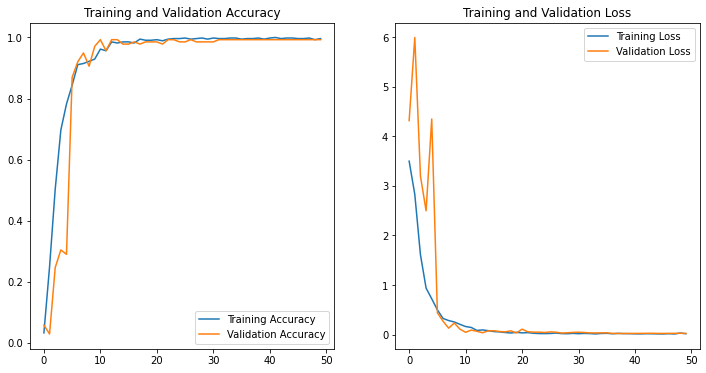

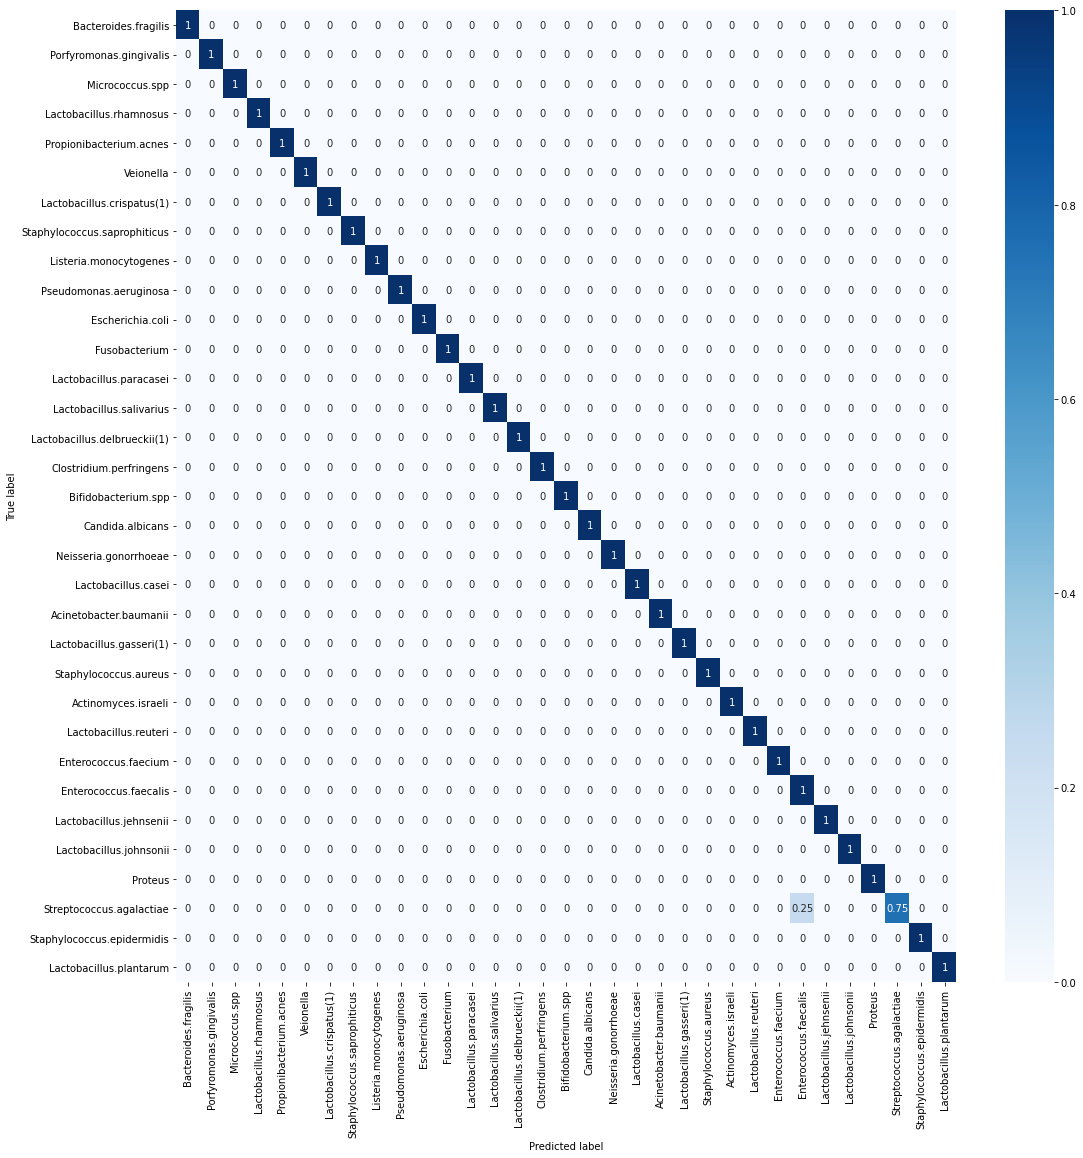


Fold  1
                   
Epoch 1/50
55/55 [==============================] - 96s 2s/step - loss: 2.2683 - accuracy: 0.4408 - val_loss: 1.1908 - val_accuracy: 0.6884
Epoch 2/50
55/55 [==============================] - 91s 2s/step - loss: 0.4358 - accuracy: 0.8936 - val_loss: 0.6953 - val_accuracy: 0.8406
Epoch 3/50
55/55 [==============================] - 91s 2s/step - loss: 0.2322 - accuracy: 0.9619 - val_loss: 0.1536 - val_accuracy: 0.9493
Epoch 4/50
55/55 [==============================] - 91s 2s/step - loss: 0.3298 - accuracy: 0.9194 - val_loss: 0.2499 - val_accuracy: 0.9203
Epoch 5/50
55/55 [==============================] - 90s 2s/step - loss: 0.1559 - accuracy: 0.9637 - val_loss: 0.2011 - val_accuracy: 0.9493
Epoch 6/50
55/55 [==============================] - 91s 2s/step - loss: 0.1282 - accuracy: 0.9708 - val_loss: 0.1023 - val_accuracy: 0.9855
Epoch 7/50
55/55 [==============================] - 91s 2s/step - loss: 0.0688 - accuracy: 0.9802 - val_loss: 0.0289 - val_accuracy

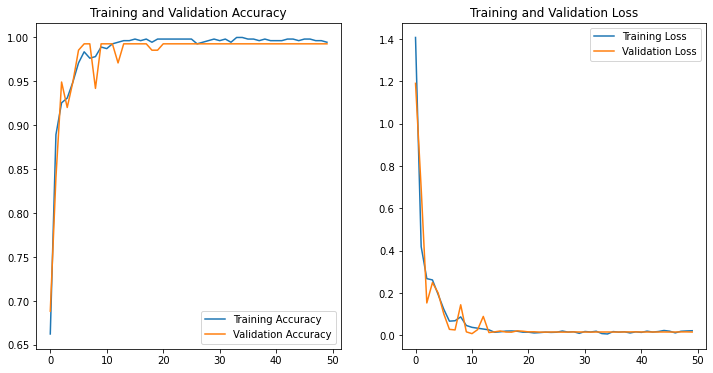

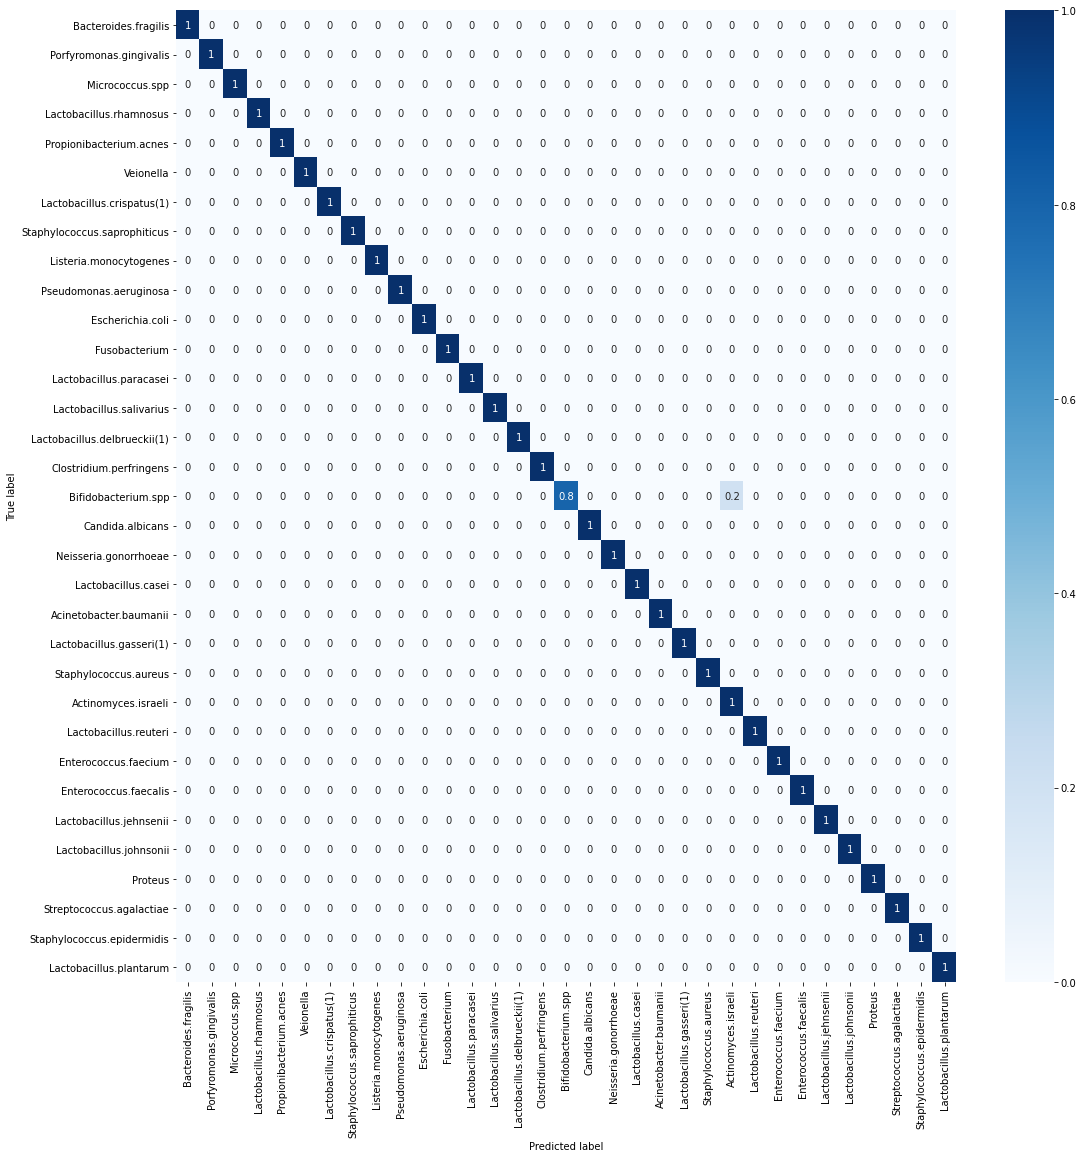


Fold  2
                   
Epoch 1/50
55/55 [==============================] - 96s 2s/step - loss: 2.2110 - accuracy: 0.4442 - val_loss: 0.4171 - val_accuracy: 0.8913
Epoch 2/50
55/55 [==============================] - 91s 2s/step - loss: 0.2590 - accuracy: 0.9452 - val_loss: 0.0538 - val_accuracy: 0.9855
Epoch 3/50
55/55 [==============================] - 91s 2s/step - loss: 0.1747 - accuracy: 0.9474 - val_loss: 0.0674 - val_accuracy: 0.9783
Epoch 4/50
55/55 [==============================] - 90s 2s/step - loss: 0.1444 - accuracy: 0.9684 - val_loss: 1.3053 - val_accuracy: 0.8188
Epoch 5/50
55/55 [==============================] - 91s 2s/step - loss: 0.2698 - accuracy: 0.9338 - val_loss: 0.0637 - val_accuracy: 0.9783
Epoch 6/50
55/55 [==============================] - 90s 2s/step - loss: 0.0738 - accuracy: 0.9864 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 7/50
55/55 [==============================] - 90s 2s/step - loss: 0.0430 - accuracy: 0.9921 - val_loss: 0.0054 - val_accuracy

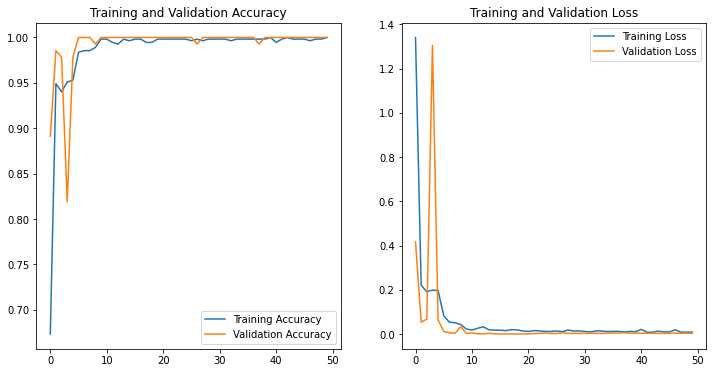

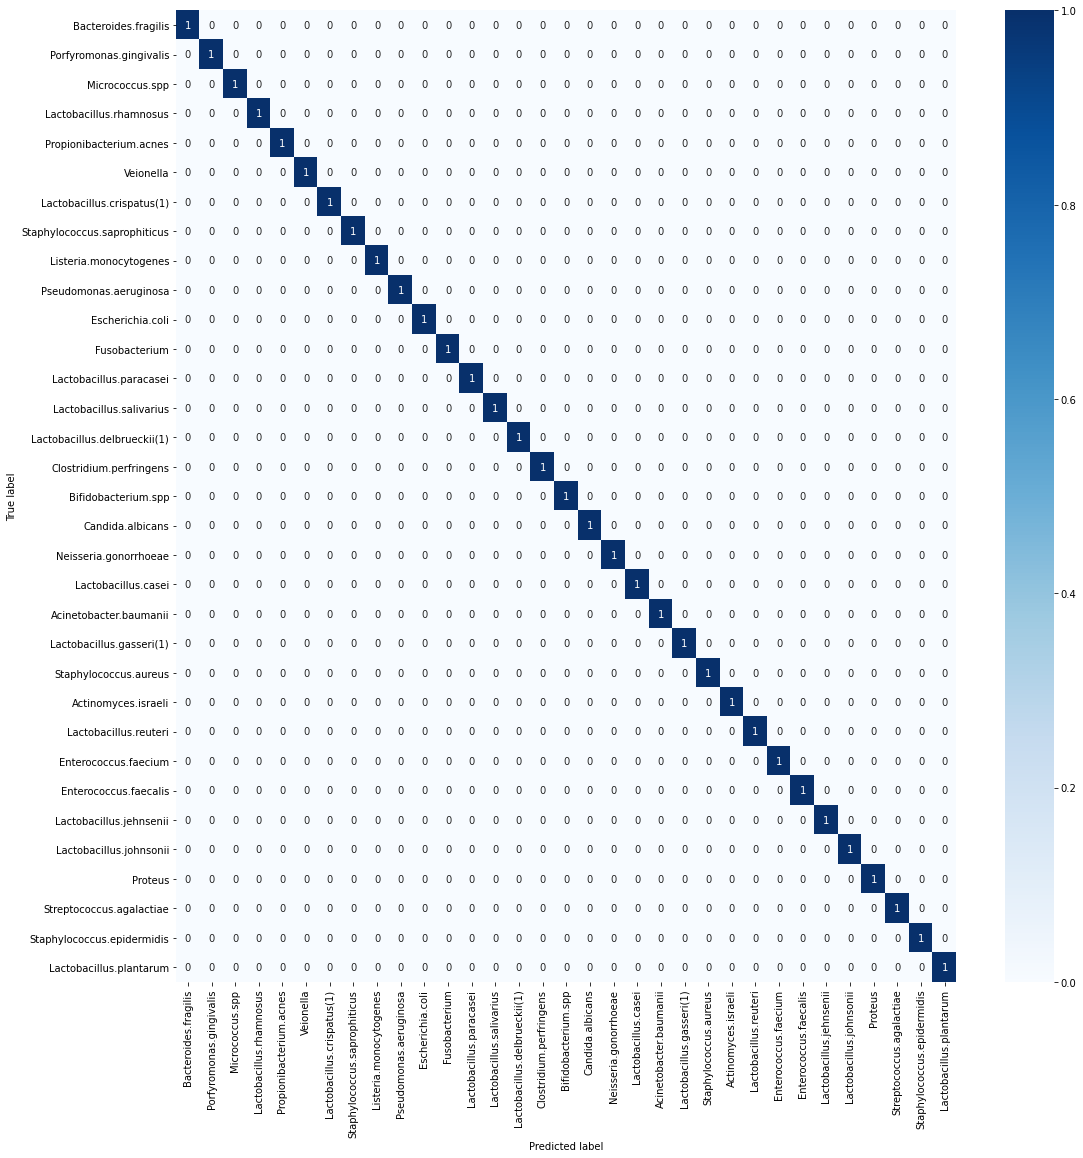


Fold  3
                   
Epoch 1/50
55/55 [==============================] - 96s 2s/step - loss: 2.2539 - accuracy: 0.4335 - val_loss: 1.0759 - val_accuracy: 0.7319
Epoch 2/50
55/55 [==============================] - 90s 2s/step - loss: 0.1575 - accuracy: 0.9747 - val_loss: 0.1086 - val_accuracy: 0.9638
Epoch 3/50
55/55 [==============================] - 92s 2s/step - loss: 0.1421 - accuracy: 0.9696 - val_loss: 0.2253 - val_accuracy: 0.9348
Epoch 4/50
55/55 [==============================] - 91s 2s/step - loss: 0.1456 - accuracy: 0.9619 - val_loss: 0.3987 - val_accuracy: 0.8913
Epoch 5/50
55/55 [==============================] - 91s 2s/step - loss: 0.1587 - accuracy: 0.9720 - val_loss: 0.4029 - val_accuracy: 0.9203
Epoch 6/50
55/55 [==============================] - 91s 2s/step - loss: 0.0856 - accuracy: 0.9762 - val_loss: 0.3015 - val_accuracy: 0.9710
Epoch 7/50
55/55 [==============================] - 92s 2s/step - loss: 0.0978 - accuracy: 0.9771 - val_loss: 0.0685 - val_accuracy

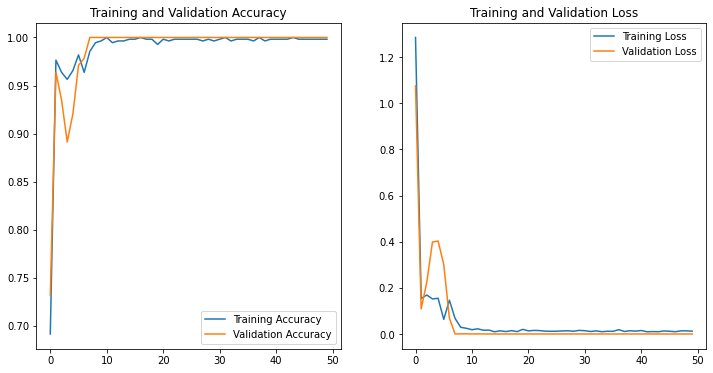

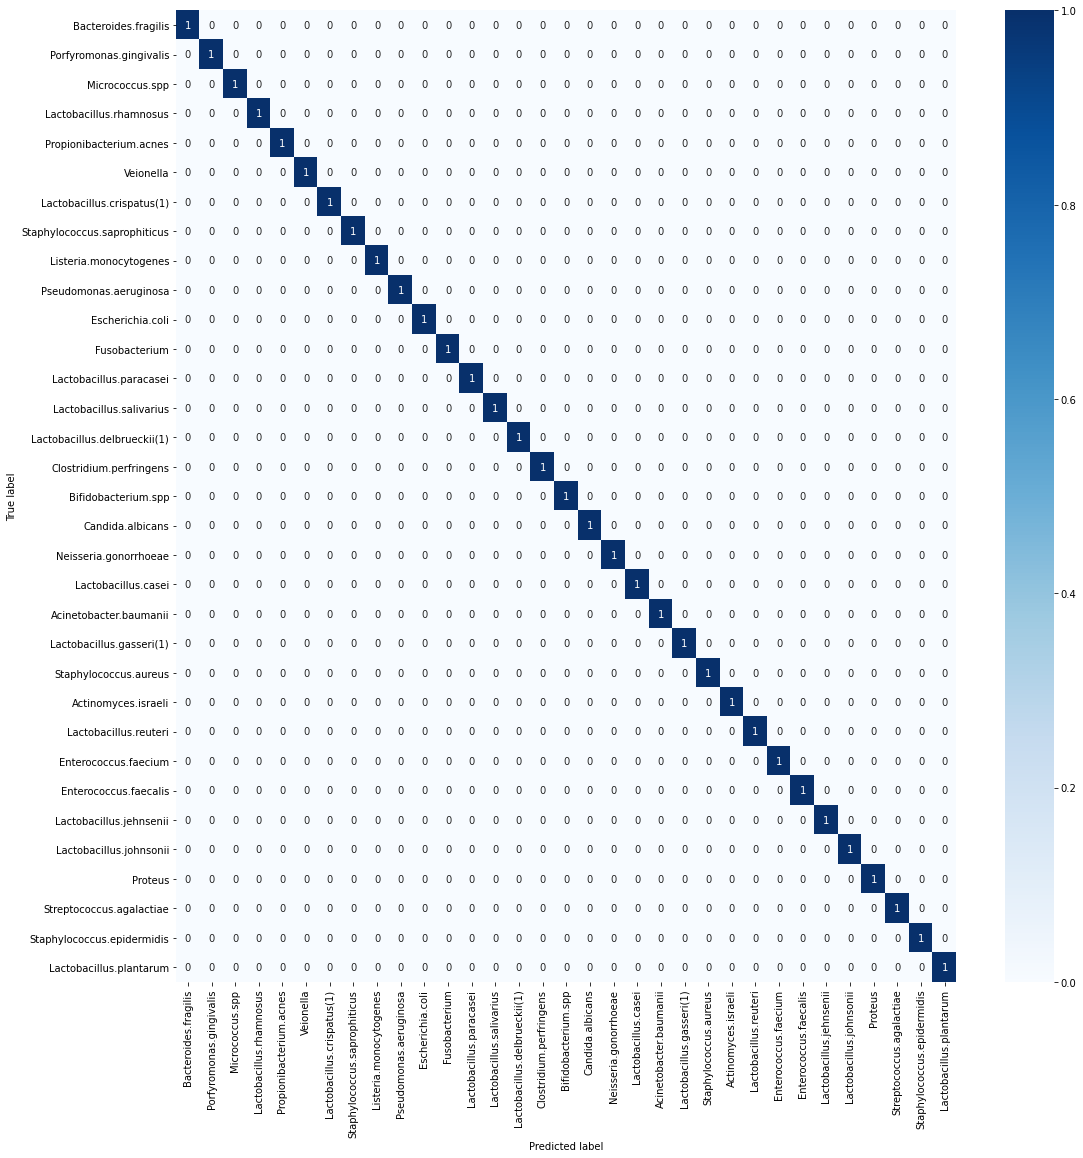


Fold  4
                   
Epoch 1/50
55/55 [==============================] - 98s 2s/step - loss: 2.3305 - accuracy: 0.4541 - val_loss: 0.1858 - val_accuracy: 0.9416
Epoch 2/50
55/55 [==============================] - 91s 2s/step - loss: 0.1572 - accuracy: 0.9769 - val_loss: 0.1382 - val_accuracy: 0.9635
Epoch 3/50
55/55 [==============================] - 91s 2s/step - loss: 0.0807 - accuracy: 0.9831 - val_loss: 0.1614 - val_accuracy: 0.9562
Epoch 4/50
55/55 [==============================] - 91s 2s/step - loss: 0.1207 - accuracy: 0.9584 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/50
55/55 [==============================] - 91s 2s/step - loss: 0.0644 - accuracy: 0.9883 - val_loss: 0.1196 - val_accuracy: 0.9781
Epoch 6/50
55/55 [==============================] - 90s 2s/step - loss: 0.0670 - accuracy: 0.9903 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/50
55/55 [==============================] - 91s 2s/step - loss: 0.0606 - accuracy: 0.9893 - val_loss: 0.0030 - val_accuracy

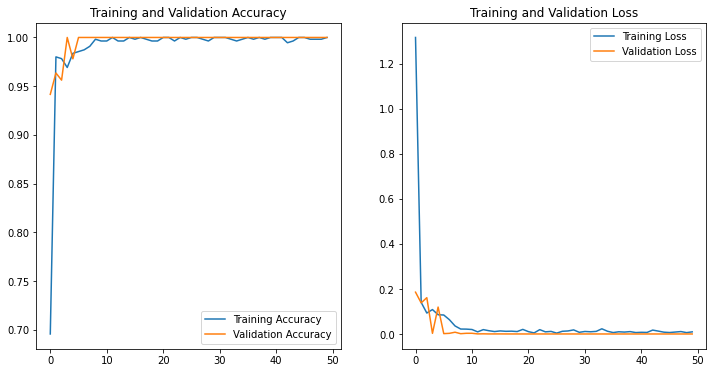

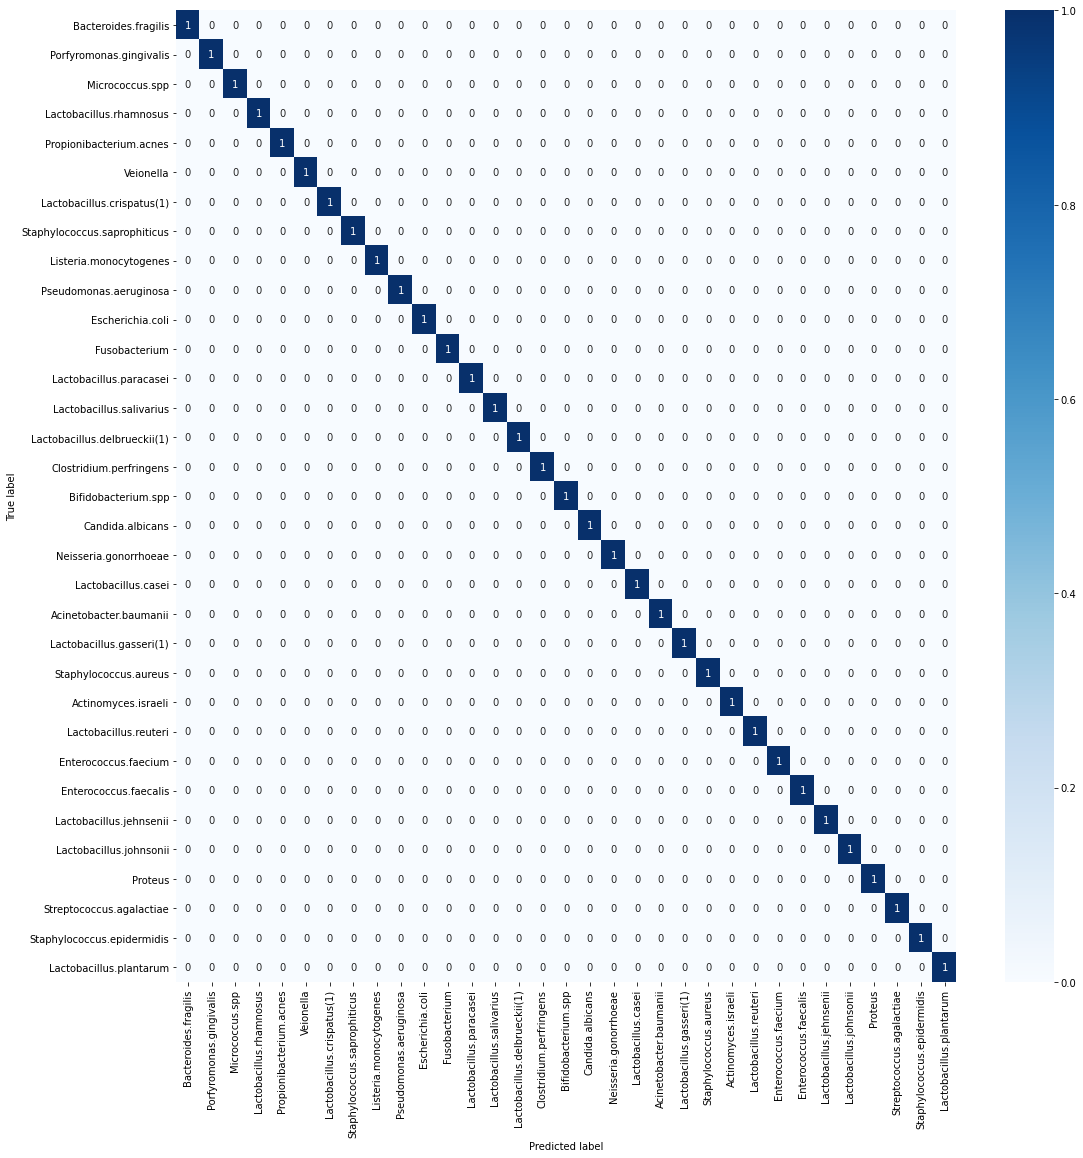

TypeError: ignored

In [ ]:
#fold 5

start = 1
end = 5

cv_sum = 0;

cv_acc_list = []

historys = []

for i in range(start-1, end):
  print('\nFold ',i)
  print('                   ')

  x_train_cv = x[folds[i][0]]
  y_train_cv = y[folds[i][0]]
  x_test_cv = x[folds[i][1]]
  y_test_cv= y[folds[i][1]]
  model = create_model(base_model)
  history = fit_model(model, x_train_cv, y_train_cv, x_test_cv, y_test_cv)

  pred = model.predict(x_test_cv)
  acc = accuracy_score(y_test_cv, pred.argmax(1))
  cv_acc_list.append(acc)
  print('CV Evaluate:', model.evaluate(x_test_cv, y_test_cv))
  cv_sum = cv_sum + acc 

  plot_history(history)
  show_con(model, x_test_cv, y_test_cv)

  historys.append(history.history)

print('5 Fold Cv Avg: ', cv_sum / 5, 'List:', cv_acc_list)
print('Model: ', base_model.name)

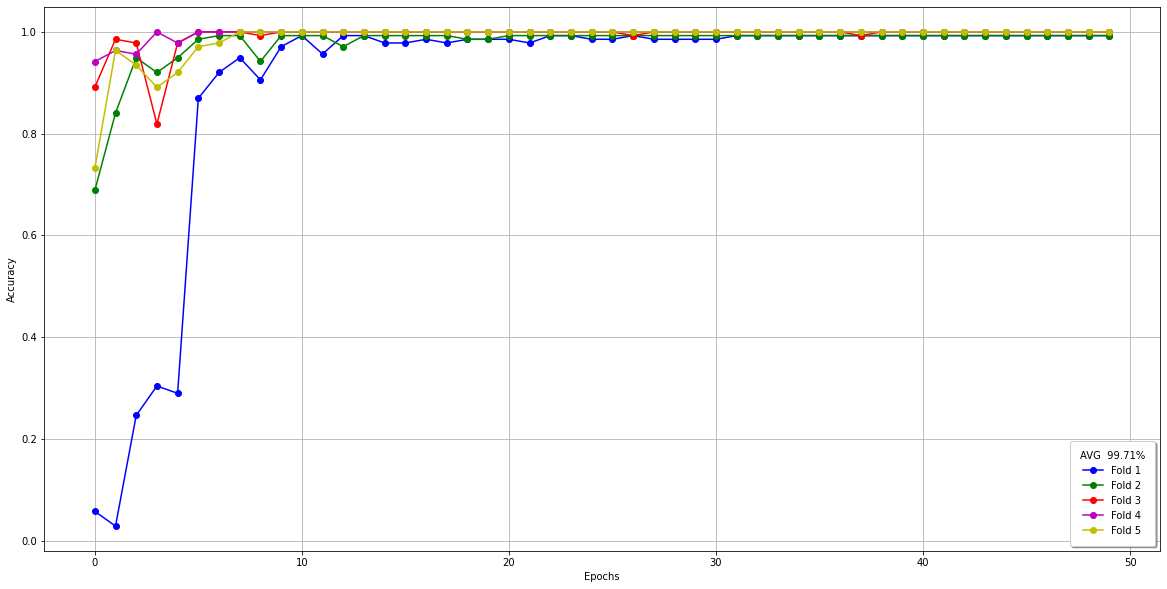

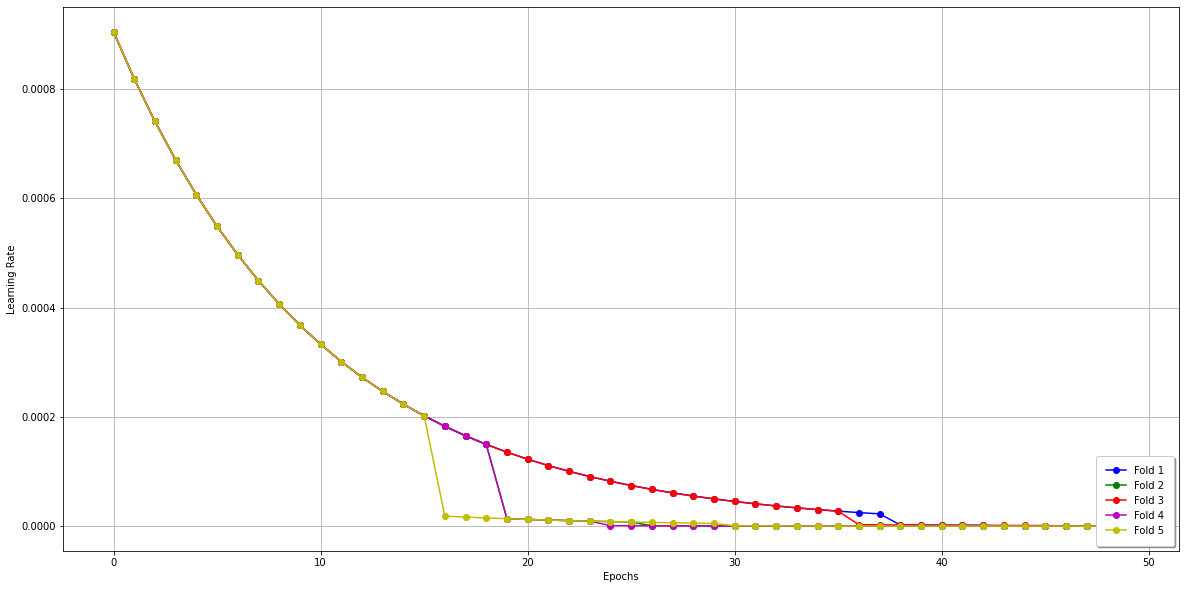

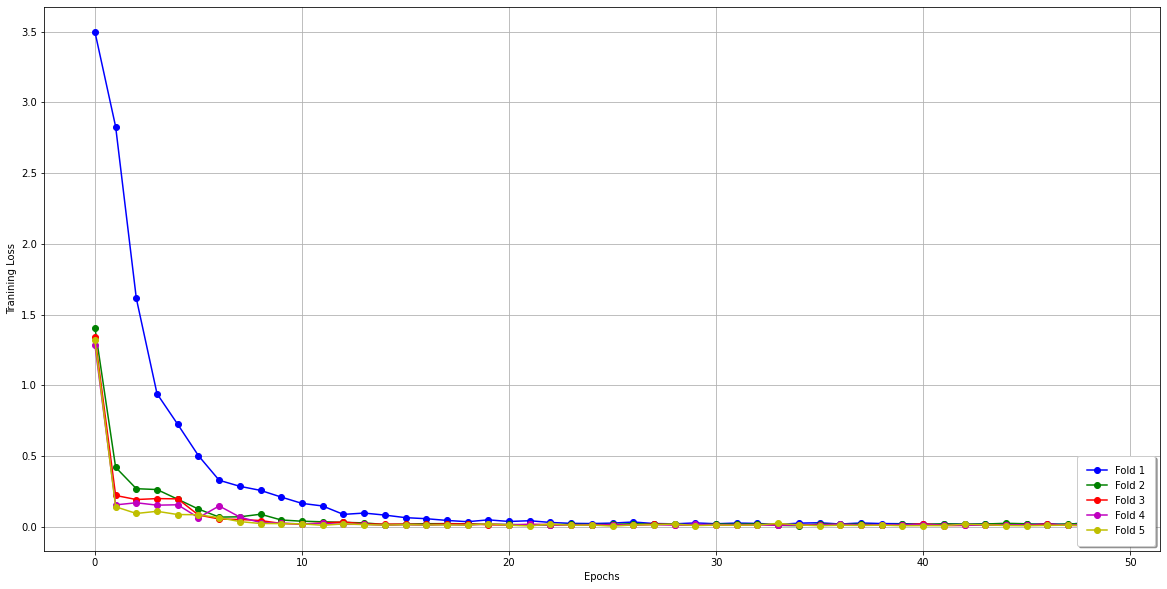

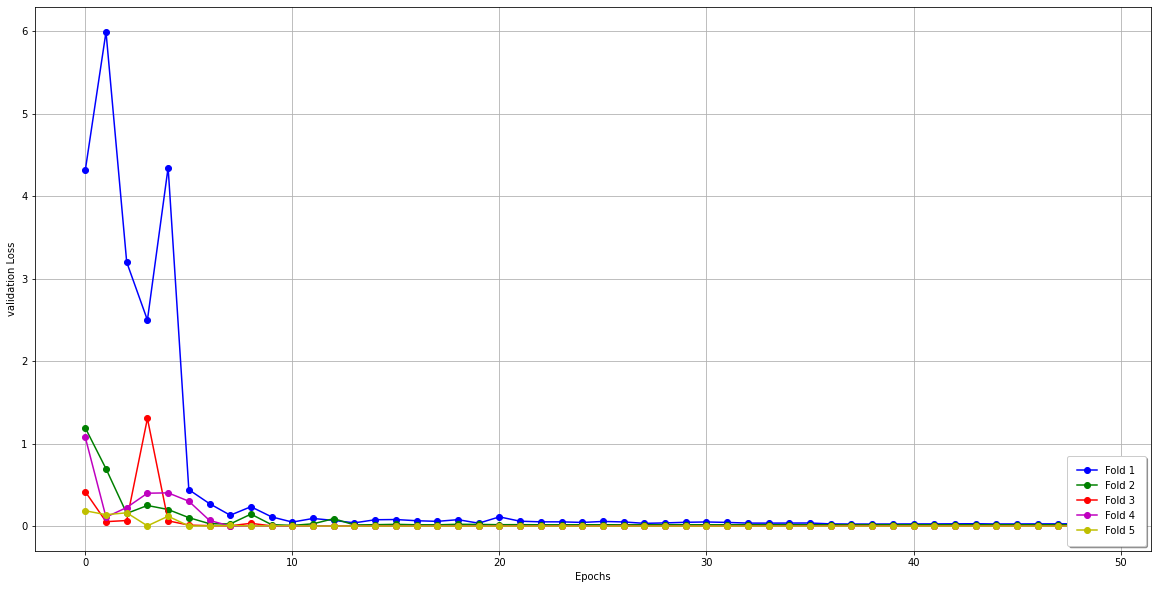

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_folds_history_acc(historys):

  val_accuracy_1 = historys[0]['val_accuracy']
  val_accuracy_2 = historys[1]['val_accuracy']
  val_accuracy_3 = historys[2]['val_accuracy']
  val_accuracy_4 = historys[3]['val_accuracy']
  val_accuracy_5 = historys[4]['val_accuracy']
  
  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(val_accuracy_0, 'ob')
  plt.plot(val_accuracy_0, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(val_accuracy_1, 'og')
  plt.plot(val_accuracy_1, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(val_accuracy_2, 'or')
  plt.plot(val_accuracy_2, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(val_accuracy_3, 'om')
  plt.plot(val_accuracy_3, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(val_accuracy_4, 'oy')
  plt.plot(val_accuracy_4, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True)

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], title='AVG ' + str(round(cv_sum / 5 * 100, 2)), framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
    
  plt.show()


def plot_folds_history_lr(historys):

  lr_1 = historys[0]['lr']
  lr_2 = historys[1]['lr']
  lr_3 = historys[2]['lr']
  lr_4 = historys[3]['lr']
  lr_5 = historys[4]['lr']

  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(lr_1, 'ob')
  plt.plot(lr_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(lr_2, 'og')
  plt.plot(lr_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(lr_3, 'or')
  plt.plot(lr_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(lr_4, 'om')
  plt.plot(lr_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(lr_5, 'oy')
  plt.plot(lr_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True) 

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Learning Rate')
    
  plt.show()


def plot_folds_history_loss(historys):

  loss_1 = historys[0]['loss']
  loss_2 = historys[1]['loss']
  loss_3 = historys[2]['loss']
  loss_4 = historys[3]['loss']
  loss_5 = historys[4]['loss']


  epochs_range = range(50)

  plt.figure(figsize=(20, 10))

  plt.grid(True) 
  
  plt.plot(loss_1, 'ob')
  plt.plot(loss_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(loss_2, 'og')
  plt.plot(loss_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(loss_3, 'or')
  plt.plot(loss_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(loss_4, 'om')
  plt.plot(loss_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(loss_5, 'oy')
  plt.plot(loss_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Tranining Loss')
    
  plt.show()

def plot_folds_history_loss_val(historys):

  val_loss_1 = historys[0]['val_loss']
  val_loss_2 = historys[1]['val_loss']
  val_loss_3 = historys[2]['val_loss']
  val_loss_4 = historys[3]['val_loss']
  val_loss_5 = historys[4]['val_loss']

  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(val_loss_1, 'ob')
  plt.plot(val_loss_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(val_loss_2, 'og')
  plt.plot(val_loss_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(val_loss_3, 'or')
  plt.plot(val_loss_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(val_loss_4, 'om')
  plt.plot(val_loss_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(val_loss_5, 'oy')
  plt.plot(val_loss_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True) 

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('validation Loss')
    
  plt.show()


plot_folds_history_acc(historys)
plot_folds_history_lr(historys)
plot_folds_history_loss(historys)
plot_folds_history_loss_val(historys)